In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information astropy, numpy, scipy, matplotlib, astroquery, photutils, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2023-04-27 21:01:27 (KST = GMT+0900) 


0 Python     3.10.10 64bit [Clang 14.0.6 ]
1 IPython    8.7.0
2 OS         macOS 13.1 arm64 arm 64bit
3 astropy    5.2.2
4 numpy      1.23.2
5 scipy      1.10.1
6 matplotlib 3.7.1
7 astroquery 0.4.7.dev8438
8 photutils  1.6.1.dev103+gad22185f
9 version_information 1.0.4


In [2]:
# %matplotlib notebook
from IPython.core.interactiveshell import InteractiveShell
from IPython import get_ipython
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'
ipython = get_ipython()

from pathlib import Path

import numpy as np

from astropy import units as u
from astropy.nddata import CCDData, Cutout2D
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.stats import sigma_clipped_stats

from astroquery.mast import Catalogs

import ysfitsutilpy as yfu
import ysphotutilpy as ypu

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('default')
rcParams.update({'font.size':12})

from photutils.aperture import (CircularAperture, CircularAnnulus, 
                                aperture_photometry, ApertureStats)
from photutils.detection import DAOStarFinder
from photutils.psf.groupstars import DAOGroup

from scipy.optimize import minimize

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

import _tool_visualization as vis

DATAPATH = Path('../../Tutorial_Data')
TMPDIR = Path('tmp')
TMPDIR.mkdir(exist_ok=True)

allfits = list(DATAPATH.glob("*p4179*.fits"))
allfits.sort()

ccd = CCDData.read(allfits[0])

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [3]:
pix_scale = 0.4*u.arcsec
center_xy = np.array(ccd.shape)/2
center_radec = ccd.wcs.wcs_pix2world(*center_xy, 0)
center_coo = SkyCoord(*center_radec, unit='deg')
fov_radius = np.sqrt((np.array(ccd.shape)**2).sum())/2 * pix_scale
q_ps = Catalogs.query_region(center_coo, radius=fov_radius, catalog="Panstarrs", 
                             data_release="dr2", table="mean")
# Change some column names for convenience.
q_ps["raMean"].name = "ra"
q_ps["decMean"].name = "dec"
q_ps["gMeanPSFMag"].name = "g"
q_ps["rMeanPSFMag"].name = "r"

# drop stars with unknown magnitudes
q_ps = q_ps.to_pandas().dropna(subset=["g", "r"])

# Calculate V and R, and their errors
q_ps["V"] = 0.006 + 0.474*q_ps["g"] + 0.526*q_ps["r"]
q_ps["R"] = -0.138 - 0.131*q_ps["g"] + 1.131*q_ps["r"]
q_ps["dV"] = np.sqrt(
    0.474**2*q_ps["gMeanPSFMagErr"]**2 
    + 0.526**2*q_ps["rMeanPSFMagErr"]**2 + 0.012**2
)
q_ps["dR"] = np.sqrt(
    0.131**2*q_ps["gMeanPSFMagErr"]**2
    + 1.131**2*q_ps["rMeanPSFMagErr"]**2 + 0.015**2
)
q_ps["dgr"] = np.sqrt(q_ps["gMeanPSFMagErr"]**2 + q_ps["rMeanPSFMagErr"]**2)

# Select only important columns
q2 = q_ps[["ra", "dec", "g", "r", "dgr", "V", "R", "dV", "dR"]].copy().reset_index(drop=True)

# Select only brighter than 22 mag
q2 = q2[(q2["V"] < 22) & (q2["R"] < 22)].copy()

# Calculate x, y position
coo = SkyCoord(q2["ra"], q2["dec"], unit='deg')
q2["x"], q2["y"] = ccd.wcs.wcs_world2pix(coo.ra, coo.dec, 0)

# Remove stars outside the image
q2 = q2[(q2["x"] > 20) & (q2["x"] < ccd.shape[1]-20) 
        & (q2["y"] > 20) & (q2["y"] < ccd.shape[0]-20)]

q2 = q2.reset_index(drop=True)

print(f"Total {len(q2)} stars from PS1 DR2")

Total 122 stars from PS1 DR2


In [4]:
q_ps

objName objAltName1 objAltName2 objAltName3  \
4     PSO J204.3924-09.5559        -999        -999        -999   
27    PSO J204.4042-09.5511        -999        -999        -999   
104   PSO J204.3031-09.5482        -999        -999        -999   
157   PSO J204.3017-09.5325        -999        -999        -999   
161   PSO J204.3021-09.5279        -999        -999        -999   
...                     ...         ...         ...         ...   
5804  PSO J204.3917-09.4498        -999        -999        -999   
5805  PSO J204.3917-09.4497        -999        -999        -999   
5838  PSO J204.4086-09.4438        -999        -999        -999   
5840  PSO J204.4099-09.4502        -999        -999        -999   
5870  PSO J204.4166-09.4431        -999        -999        -999   

                  objID    uniquePspsOBid         ippObjID  surveyID  \
4     96532043924553423  3483584000019194  422766515866362         0   
27    96532044043479058  3483584000020853  422766515868021         0   
104   96542043031412645  3483584000006528  422766515853695         0   
157   96562043018691421  3483584000006328  422766515853495         0   
161   96562043021636917  3483584000006382  422766515853549         0   
...                 ...               ...              ...       ...   
5804  96662043915330584  3483584000019073  422766515866241         0   
5805  96662043917680769  3483584000019104  422766515866272         0   
5838  96662044086877918  3483584000021409  422766515868577         0   
5840  96662044100090080  3483584000021584  422766515868752         0   
5870  96662044166628767  3483584000022478  422766515869646         0   

               htmID  zoneID  ...  yMeanApMagErr  yMeanApMagStd  \
4     11154820250591    9653  ...       0.042918       0.141706   
27    11154820540439    9653  ...            NaN            NaN   
104   11154814006035    9654  ...            NaN            NaN   
157   11154814117297    9656  ...            NaN            NaN   
161   11154813899098    9656  ...       0.010955       0.042199   
...              ...     ...  ...            ...            ...   
5804  11154819549535    9666  ...            NaN            NaN   
5805  11154819549535    9666  ...       0.041369       0.212259   
5838  11154819495492    9666  ...            NaN            NaN   
5840  11154819614918    9666  ...       0.079006       0.310071   
5870  11154819318280    9666  ...       0.014181       0.042819   

      yMeanApMagNpt    yFlags  distance          V          R        dV  \
4                 9    115000  0.066363  21.854649  21.354607  0.094928   
27                0     16416  0.068621  21.826317  21.284833  0.106012   
104               0     16416  0.077430  22.208159  21.729292  0.175624   
157               0         0  0.069202  21.189012  20.498456  0.200085   
161              10    115000  0.066580  19.947791  19.024067  0.019895   
...             ...       ...       ...        ...        ...       ...   
5804              0         0  0.055511  20.822059  19.415908  0.114143   
5805             11    115000  0.055528  20.256139  19.352137  0.023311   
5838              0         0  0.070311  19.604117  22.010796  0.128299   
5840             11  16892216  0.066478  20.952707  20.289981  0.061518   
5870              7    115000  0.076201  18.062088  17.458228  0.012665   

            dR       dgr  
4     0.089374  0.195354  
27    0.102516  0.218276  
104   0.213523  0.358783  
157   0.311014  0.400439  
161   0.030402  0.031553  
...        ...       ...  
5804  0.057990  0.238644  
5805  0.034164  0.040125  
5838  0.275046  0.242849  
5840  0.117752  0.117238  
5870  0.016542  0.008018  

[213 rows x 130 columns]

In [5]:
def group_stars(table, crit_separation, xcol="x", ycol="y", index_only=True):
    ''' Group stars using DAOGROUP algorithm and return row indices.

    Parameters
    ----------
    table : astropy.table.Table
        The queried result table.

    crit_separation : float or int
        Distance, in units of pixels, such that any two stars separated by less
        than this distance will be placed in the same group.

    xcol, ycol : str, optional
        The column names for x and y positions. This is necessary since
        `~photutils.DAOGroup accepts a table which has x y positions designated
        as ``"x_0"`` and ``"y_0"``.

    index : bool, optional
        Whether to return only the index of the grouped rows (group information
        is lost) or the full grouped table (after group_by).

    Notes
    -----
    Assuming the psf fwhm to be known, ``crit_separation`` may be set to
    ``k * fwhm``, for some positive real k.

    See Also
    --------
    photutils.DAOStarFinder

    References
    ----------
    [1] Stetson, Astronomical Society of the Pacific, Publications,
        (ISSN 0004-6280), vol. 99, March 1987, p. 191-222.
        Available at: http://adsabs.harvard.edu/abs/1987PASP...99..191S

    Return
    ------
    gtab: Table
        Returned when ``index_only=False``. The table underwent
        ``.group_by("group_id")``.

    grouped_rows: list
        Returned when ``index_only=True``.
        The indices of the rows which are "grouped" stars. You may remove such
        rows using ``table.remove_rows(grouped_rows)``.
    '''

    # Convert to astropy.Table because DAOGroup only accepts astropy.Table.
    if not isinstance(table, Table):
        table = Table.from_pandas(table)
    tab = table.copy()

    tab[xcol].name = "x_0"
    tab[ycol].name = "y_0"
    try:
        gtab = DAOGroup(crit_separation=crit_separation)(tab)
    except IndexError:  # empty tab (len(tab) == 0)
        gtab = tab
        gtab["group_id"] = []
        gtab["id"] = []

    if not index_only:
        gtab["x_0"].name = xcol
        gtab["y_0"].name = ycol
        return gtab
    else:
        gid, gnum = np.unique(gtab["group_id"], return_counts=True)
        gmask = gid[gnum != 1]  # group id with > 1 stars
        grouped_rows = []
        for i, gid in enumerate(gtab["group_id"]):
            if gid in gmask:
                grouped_rows.append(i)
        return grouped_rows


rows2rm = group_stars(q2, crit_separation=20) 
q2_close = q2.drop(rows2rm, axis=0).reset_index(drop=True)

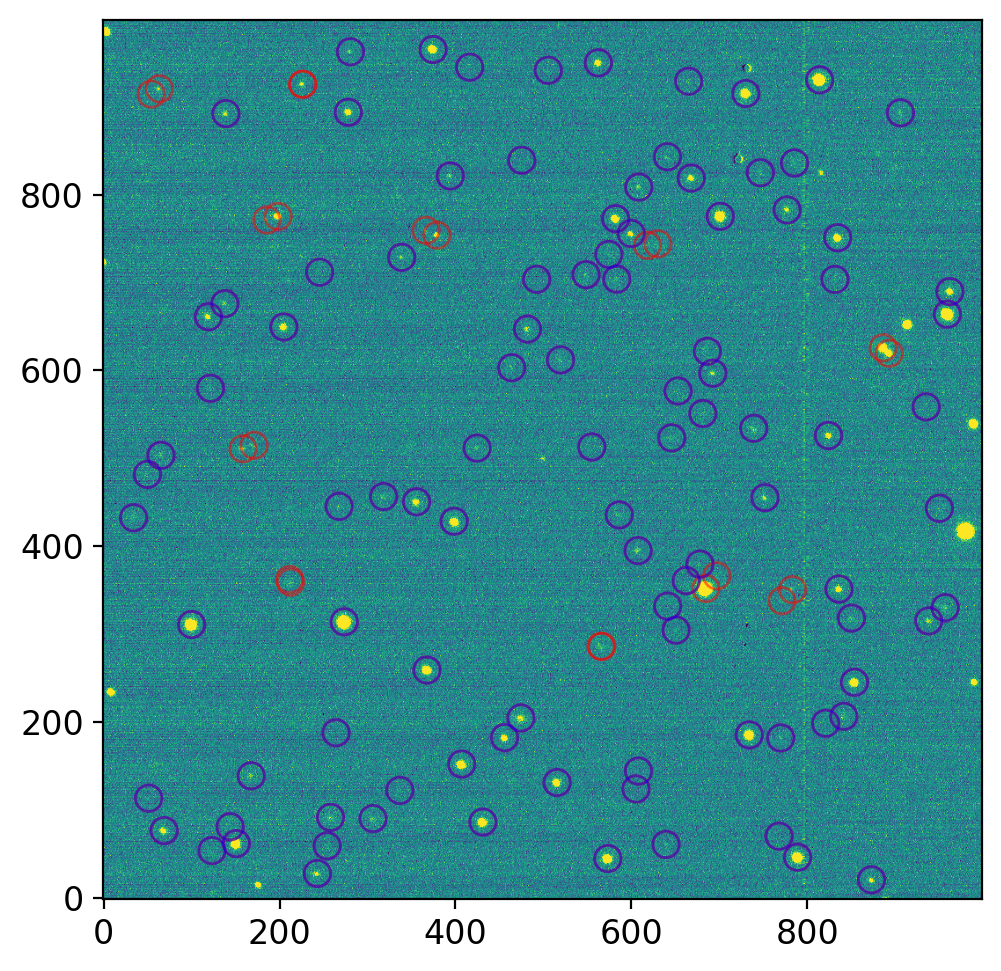

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

aps_all = CircularAperture(np.array([q2["x"], q2["y"]]).T, r=15)
aps_close = CircularAperture(np.array([q2_close["x"], q2_close["y"]]).T, r=15)

vis.norm_imshow(axs, ccd.data, zscale=True)

aps_all.plot(color="r", lw=1, alpha=0.5, ax=axs)
aps_close.plot(color="blue", lw=1, alpha=0.5, ax=axs)

plt.tight_layout()
plt.show();

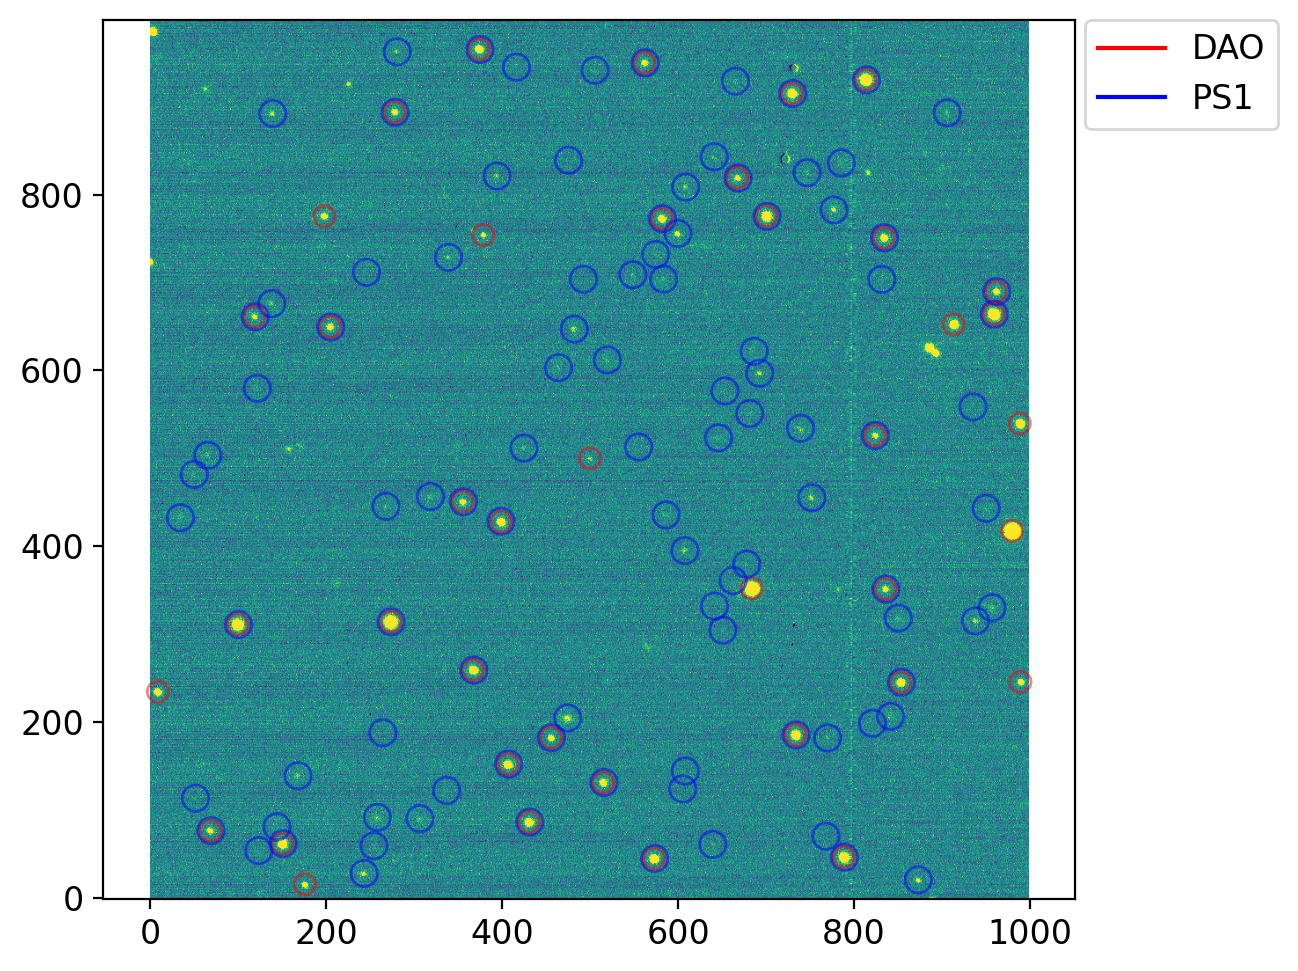

In [7]:
avg, med, std = sigma_clipped_stats(ccd.data)  # by default, 3-sigma 5-iteration.
finder = DAOStarFinder(
    fwhm=4,  # In reality, FWHM must be measured a priori using, e.g., `ginga`
    threshold=5 * std, 
    sharplo=0.2, sharphi=1.0,   # default values 0.2 and 1.0
    roundlo=-1.0, roundhi=1.0,  # default values -1 and +1
    sigma_radius=1.5,           # default values 1.5
    ratio=1.0,                  # 1.0: circular gaussian
    exclude_border=True         # To exclude sources near edges
)

# The DAOStarFinder object ``finder`` gets at least one input: the image.
# Then it returns the astropy table which contains the aperture photometry results:
dao = finder(ccd.data - med)  

# Drop nearby objects
rows2rm = group_stars(dao, crit_separation=20, xcol="xcentroid", ycol="ycentroid")
dao = dao.to_pandas().drop(rows2rm, axis=0).reset_index(drop=True)

# Plot
aps_dao = CircularAperture(np.array((dao['xcentroid'], dao['ycentroid'])).T, r=12)

fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

vis.norm_imshow(axs, ccd.data, zscale=True)

aps_dao.plot(color="r", lw=1, alpha=0.5, ax=axs)
aps_close.plot(color="b", lw=1, alpha=0.5, ax=axs)
for c, l in zip("rb", ["DAO", "PS1"]):
    axs.plot([], [], c=c, label=l)
axs.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show();

In [8]:
q2_close["xcentroid"], q2_close["ycentroid"] = None, None

for i, row in q2_close.iterrows():
    x, y = row["x"], row["y"]
    # Find closest DAOStarFinder source with distance no larger than 5 pix
    dx = dao["xcentroid"] - x
    dy = dao["ycentroid"] - y
    candidate = dao[(abs(dx) < 5) & (abs(dy) < 5)]
    if len(candidate) == 0:
        continue

    # Find the closest one
    if len(candidate) > 1:
        candidate = candidate[np.argmin(np.hypot(dx, dy))]
    
    q2_close.loc[i, "xcentroid"] = candidate["xcentroid"][0]
    q2_close.loc[i, "ycentroid"] = candidate["ycentroid"][0]
q2_close = q2_close.dropna(axis=0, subset="xcentroid").reset_index(drop=True)

KeyError: 0

In [9]:
q2_xy = np.array([q2_close["xcentroid"], q2_close["ycentroid"]]).T
ap_stars = CircularAperture(q2_xy, r=15)
an_stars = CircularAnnulus(q2_xy, r_in=25, r_out=40)
phot = ypu.apphot_annulus(ccd, ap_stars, an_stars).drop(["xcenter", "ycenter"], axis=1)
phot = q2_close.join([phot])

ValueError: 'positions' must not contain any non-finite (e.g., NaN or inf) positions

In [10]:
from scipy.optimize import curve_fit

def linf(x, a, b):
    return a + b*x

mcat, dmcat = phot["V"], phot["dV"]
mobs, dmobs = phot["mag"], phot["merr"]
color = phot["g"] - phot["r"]
dmtot = np.sqrt(dmcat**2 + dmobs**2)

# === Calculate zero point and errors
zeropt = np.average(mobs - mcat, weights=1/dmtot**2)
dzeropt = np.max([1/np.sqrt(np.sum(1/dmtot**2)), np.std(mobs - mcat, ddof=1)/np.sqrt(len(mcat))])
dmtot2 = np.sqrt(dmtot**2 + dzeropt**2)

# === Find fitting lines
# Search for the usage of scipy.optimize.curve_fit.
poptm, _ = curve_fit(linf, mcat, mobs, sigma=dmobs, absolute_sigma=True)
poptc, _ = curve_fit(linf, color, mobs-mcat, sigma=dmtot2, absolute_sigma=True)

# === Plot
# --- Set some useful things
vv = np.arange(-100, 100, 10)
cc = np.array([color.min(), color.max()])
errkw = dict(marker="", ls="", ecolor="gray", elinewidth=0.5)

# --- Main plot with error bars and fitting lines
fig, axs = plt.subplot_mosaic("mc\nmc\nrc", figsize=(8, 5))
# m = magnitudes, c=colors, r=residuals
axs["m"].plot(mcat, mobs, "k.", ms=5)
axs["m"].errorbar(mcat, mobs, xerr=dmcat, yerr=dmobs, **errkw)

# Fitted lines
axs["m"].plot(vv, zeropt + vv, "r-", lw=1, label=f"y = x {zeropt:+.3f} (fix slope)")
axs["m"].plot(vv, linf(vv, *poptm), "b:", lw=1, 
              label=f"y = {poptm[1]:+.3f}x {poptm[0]:+.3f}")

axs["r"].plot(mcat, mobs - mcat - zeropt, "k.", ms=5)
axs["r"].errorbar(mcat, mobs - mcat - zeropt, xerr=dmcat, yerr=dmtot2, **errkw)

axs["c"].plot(color, mobs - mcat, "k.", ms=5)
axs["c"].errorbar(color, mobs - mcat, xerr=phot["dgr"], yerr=dmtot2, **errkw)
axs["c"].plot(cc, linf(cc, *poptc), "r-", lw=1, label=f"y = {poptc[1]:+.3f}x {poptc[0]:+.3f}")

# --- Some codes to make the plot prettier
for i, row in phot.iterrows():
    axs["m"].text(row["V"], row["mag"], i, fontsize=8)
    axs["r"].text(row["V"], row["mag"] - row["V"] - zeropt, i, fontsize=8)
    axs["c"].text(row["g"] - row["r"], row["mag"] - row["V"], i, fontsize=8)

axs["m"].set(xlim=(15.5, 20), ylim=(-8, -3), ylabel="v (Instrumental V-mag)")
axs["r"].set(xlim=(15.5, 20), ylim=np.array([-1, 1])*np.max(np.abs(axs["r"].get_ylim())), 
             ylabel="v - V_PS1 - Z", xlabel="PS1 V-mag")
axs["c"].set(title="v - V_PS1", xlabel="g - r (PS1)")

axs["r"].axhline(0, color="k", lw=1)
axs["c"].axhline(zeropt, color="k", lw=1, label=f"Z = {zeropt:.3f} ± {dzeropt:.3f}")
axs["r"].hlines([dzeropt, -dzeropt], -10, 100, color="k", lw=1, ls=":" )
axs["c"].hlines([zeropt+dzeropt, zeropt-dzeropt], color.min(), color.max(), color="k", lw=1, ls=":" )
axs["m"].legend(fontsize=10)
axs["c"].legend(fontsize=10)

plt.tight_layout()
plt.show()

NameError: name 'phot' is not defined

ra       dec          g          r          V          R  \
0   204.360484 -9.537252  18.918200  18.661100  18.788965  18.489420   
1   204.372562 -9.534915  18.349100  18.101601  18.224915  17.931178   
2   204.376820 -9.523145  18.553301  17.914900  18.223502  17.693269   
3   204.387249 -9.517086  16.251900  16.022900  16.137446  15.854901   
4   204.406641 -9.517380  16.920099  16.598400  16.756886  16.418258   
5   204.369963 -9.542170  18.579300  17.738100  18.142829  17.489903   
6   204.401293 -9.544794  17.974100  17.651400  17.810360  17.471126   
7   204.373147 -9.504537  18.988100  17.815599  18.377365  17.524002   
8   204.377883 -9.502093  19.466000  19.481100  19.479942  19.345078   
9   204.395042 -9.466305  19.764799  18.654699  19.186887  18.371276   
10  204.410444 -9.543147  19.949100  19.042500  19.478228  18.785735   
11  204.322624 -9.524781  18.504400  17.985399  18.237406  17.779410   
12  204.394471 -9.480151  19.399200  18.834900  19.108378  18.622977   
13  204.404043 -9.478855  20.385300  19.256901  19.797762  18.971081   
14  204.325526 -9.493902  20.219700  19.191299  19.684761  18.918579   
15  204.324056 -9.469145  19.126499  18.506001  18.806117  18.286715   
16  204.335486 -9.451057  18.181700  17.666901  17.916915  17.461462   
17  204.374899 -9.468714  20.582300  19.354200  19.942320  19.055319   
18  204.385968 -9.453272  19.889999  18.837999  19.342647  18.562187   
19  204.324440 -9.513110  19.802000  19.544500  19.672555  19.372768   
20  204.341324 -9.513019  16.139500  15.540900  15.830636  15.324484   
21  204.326106 -9.449368  17.018200  16.533001  16.768985  16.331440   
22  204.336039 -9.531330  17.896799  17.555300  17.723170  17.372563   
23  204.330423 -9.465651  20.862301  19.602699  20.205750  19.299691   
24  204.354148 -9.447167  19.893700  18.702700  19.273234  18.408679   
25  204.375115 -9.445436  18.942101  17.854401  18.375970  17.573912   
26  204.330108 -9.546630  17.793301  16.982500  17.372820  16.738285   
27  204.354173 -9.546763  18.205601  17.731701  17.962329  17.531620   
28  204.367080 -9.531621  19.521400  18.847900  19.173139  18.621672   
29  204.309915 -9.475925  19.578300  19.113701  19.339921  18.914838   
30  204.310272 -9.478751  16.999599  16.666800  16.830547  16.485203   
31  204.317701 -9.483633  19.583900  18.407700  18.971219  18.115617   
32  204.318465 -9.482944  18.653400  17.534100  18.070648  17.249471   
33  204.338910 -9.466437  17.787001  17.224600  17.497178  17.012925   
34  204.342530 -9.461640  20.026501  19.360701  19.682290  19.135481   
35  204.352190 -9.466705  19.158899  18.009300  18.560210  17.720703   
36  204.391725 -9.449751  21.913401  19.827200  20.822059  19.415908   
37  204.391725 -9.449731  20.910900  19.654699  20.256139  19.352137   

          dV        dR           x           y  ...  nsky nrej      aparea  \
0   0.016274  0.024150  515.653167  131.402240  ...  3061    9  706.858347   
1   0.012941  0.017583  407.142567  152.443176  ...  3043   11  706.858347   
2   0.013901  0.020472  367.682141  259.376768  ...  3059    9  706.858347   
3   0.012142  0.015379  273.597033  314.218526  ...  3060    3  706.858347   
4   0.012241  0.015522  100.018964  311.106124  ...  3054    6  706.858347   
5   0.013157  0.017456  431.255563   86.504457  ...  3051   10  706.858347   
6   0.012964  0.017497  150.902974   62.031846  ...  3051   12  706.858347   
7   0.014736  0.023163  398.529399  428.545181  ...  3057    9  706.858347   
8   0.014178  0.020384  355.844963  450.641530  ...  3053    9  706.858347   
9   0.013668  0.016462  198.386762  775.109923  ...  3054   12  706.858347   
10  0.021401  0.031288   68.791659   76.814691  ...  3056   14  706.858347   
11  0.012597  0.016538  853.773794  245.408823  ...  3056    8  706.858347   
12  0.014237  0.019777  204.958474  649.483020  ...  3055    5  706.858347   
13  0.015003  0.019107  119.148541  660.988504  ...  3051    8  706.858347   
14  0.014443  0.020025  824.22711